In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU (UUID: GPU-68b49d17-5b7a-b859-2583-571e8615da79)


In [2]:
# For connect SQL
from query_sql import query_stmt
from db_connection import mydb_engine
from sqlalchemy import exc, text, bindparam

# For time stamps
from datetime import datetime

# For data dataframe 
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
sns.set(rc={'figure.dpi':150})

from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, LSTM, BatchNormalization
from keras.callbacks import History , ModelCheckpoint
from keras.metrics import RootMeanSquaredError

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )



# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow 2.10.1
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
# Load dataset
stmt = """ select * from eth_price;"""
t = text(stmt)
df = pd.read_sql(t,con=mydb_engine)
df

,datetime,open,high,low,close,volume,pct_chg,w_avg_price
0,2023-12-07 19:50:06,2265.27,2284.6,2220.0,2250.12,346229.8826,-0.669,2251.618661
1,2023-12-07 19:50:07,2265.27,2284.6,2220.0,2250.30,346234.7202,-0.661,2251.618640
2,2023-12-07 19:50:08,2265.27,2284.6,2220.0,2250.42,346238.9048,-0.656,2251.618625
3,2023-12-07 19:50:09,2265.27,2284.6,2220.0,2250.42,346238.9048,-0.656,2251.618625
4,2023-12-07 19:50:10,2265.27,2284.6,2220.0,2250.42,346238.9490,-0.656,2251.618625
...,...,...,...,...,...,...,...,...
29568,2023-12-08 04:13:37,2259.78,2360.0,2220.0,2354.66,473454.9189,4.199,2285.303926
29569,2023-12-08 04:13:38,2259.78,2360.0,2220.0,2354.66,473455.1169,4.199,2285.303955
29570,2023-12-08 04:13:39,2259.78,2360.0,2220.0,2354.65,473457.0187,4.198,2285.304234
29571,2023-12-08 04:13:40,2259.78,2360.0,2220.0,2354.65,473457.0434,4.198,2285.304237


In [4]:
df.tail(10)

,datetime,open,high,low,close,volume,pct_chg,w_avg_price
29563,2023-12-08 04:13:32,2259.78,2360.0,2220.0,2354.65,473453.2389,4.198,2285.303680
29564,2023-12-08 04:13:33,2259.78,2360.0,2220.0,2354.66,473453.6236,4.199,2285.303736
29565,2023-12-08 04:13:34,2259.78,2360.0,2220.0,2354.66,473454.1974,4.199,2285.303821
29566,2023-12-08 04:13:35,2259.78,2360.0,2220.0,2354.66,473454.8956,4.199,2285.303923
29567,2023-12-08 04:13:36,2259.78,2360.0,2220.0,2354.66,473454.9189,4.199,2285.303926
29568,2023-12-08 04:13:37,2259.78,2360.0,2220.0,2354.66,473454.9189,4.199,2285.303926
29569,2023-12-08 04:13:38,2259.78,2360.0,2220.0,2354.66,473455.1169,4.199,2285.303955
29570,2023-12-08 04:13:39,2259.78,2360.0,2220.0,2354.65,473457.0187,4.198,2285.304234
29571,2023-12-08 04:13:40,2259.78,2360.0,2220.0,2354.65,473457.0434,4.198,2285.304237
29572,2023-12-08 04:13:41,2259.78,2360.0,2220.0,2354.65,473457.3348,4.198,2285.304280


Descriptive Statistics about the Data

In [5]:
# Summary Stats
df.describe()

,datetime,open,high,low,close,volume,pct_chg,w_avg_price
count,29573,29573.000000,29573.000000,29573.0,29573.000000,29573.000000,29573.000000,29573.000000
mean,2023-12-08 00:03:01.508740864,2264.231594,2330.541231,2220.0,2312.829126,414886.079684,2.145404,2267.940589
min,2023-12-07 19:50:06,2248.190000,2284.600000,2220.0,2243.820000,335654.132700,-0.802000,2250.673358
25%,2023-12-07 21:57:33,2259.670000,2284.600000,2220.0,2267.100000,346987.114100,0.563000,2251.522211
50%,2023-12-08 00:03:40,2263.970000,2353.240000,2220.0,2333.480000,435682.100200,2.895000,2271.954133
75%,2023-12-08 02:08:51,2269.250000,2356.000000,2220.0,2342.160000,468148.518400,3.321000,2280.311580
max,2023-12-08 04:13:41,2284.480000,2360.000000,2220.0,2359.400000,473623.001900,4.490000,2285.304280
std,NaN,7.102325,31.155169,0.0,38.640079,52991.270824,1.621168,12.872148


Information About the Data

In [6]:
# General info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29573 entries, 0 to 29572
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     29573 non-null  datetime64[ns]
 1   open         29573 non-null  float64       
 2   high         29573 non-null  float64       
 3   low          29573 non-null  float64       
 4   close        29573 non-null  float64       
 5   volume       29573 non-null  float64       
 6   pct_chg      29573 non-null  float64       
 7   w_avg_price  29573 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.8 MB


Closing Price

Text(0, 0.5, 'Price(USD)')

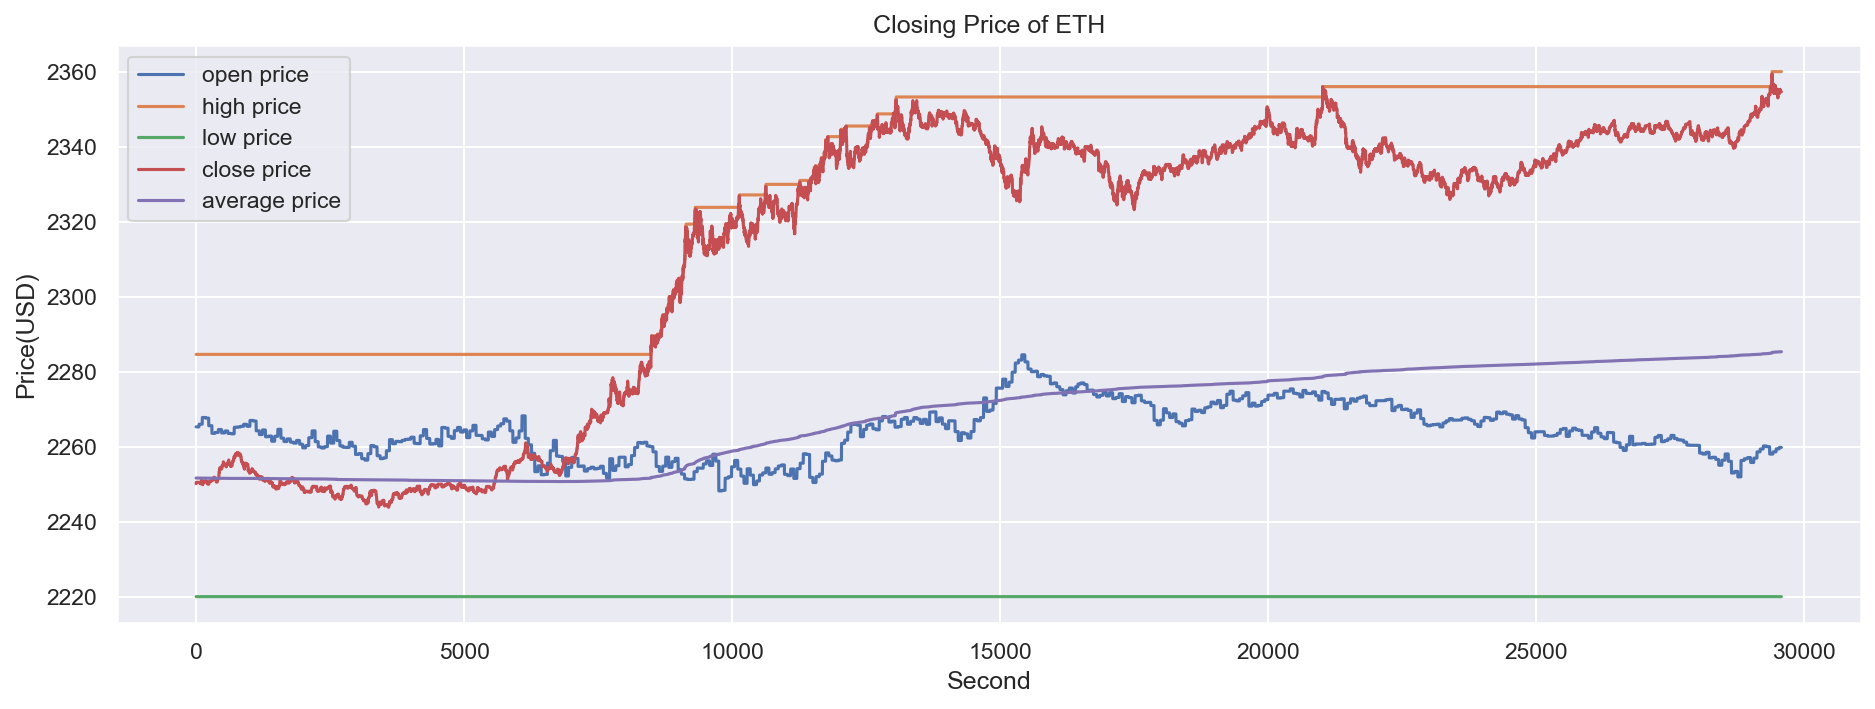

In [7]:
plt.figure(figsize=(15,5))
plt.plot(df['open'],label='open price')
plt.plot(df['high'],label='high price')
plt.plot(df['low'],label='low price')
plt.plot(df['close'],label='close price')
plt.plot(df['w_avg_price'],label='average price')
plt.legend()
plt.title('Closing Price of ETH')
plt.xlabel('Second')
plt.ylabel('Price(USD)')

Volume of Sales

Text(0, 0.5, 'Volume')

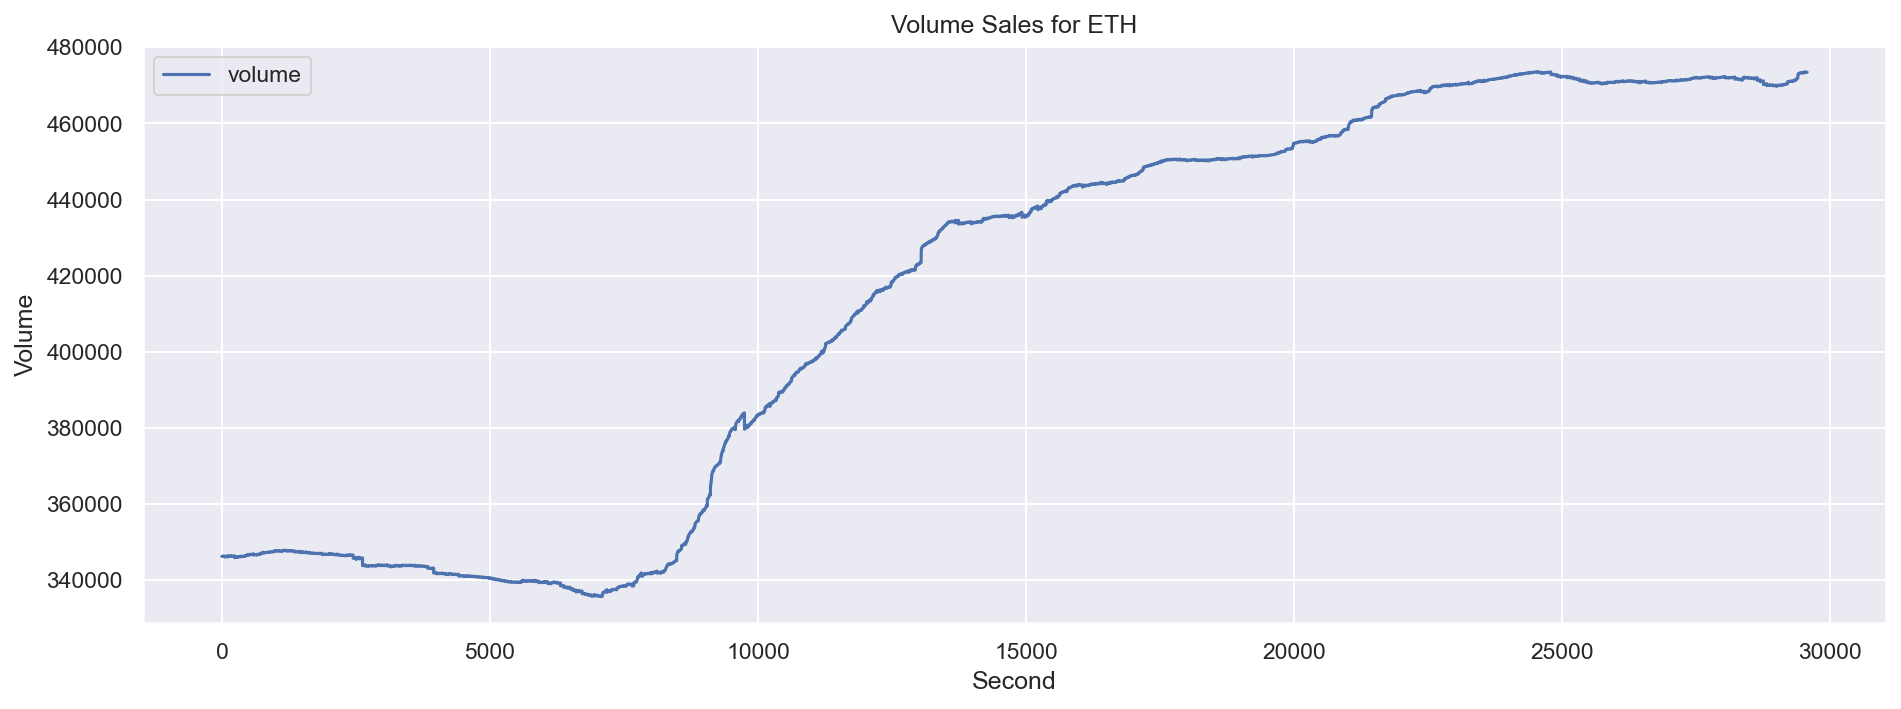

In [8]:
plt.figure(figsize=(15,5))
plt.plot(df["volume"],label='volume')
plt.legend()
plt.title('Volume Sales for ETH')
plt.xlabel('Second')
plt.ylabel('Volume')

Price change

Text(0, 0.5, 'Price(USD)')

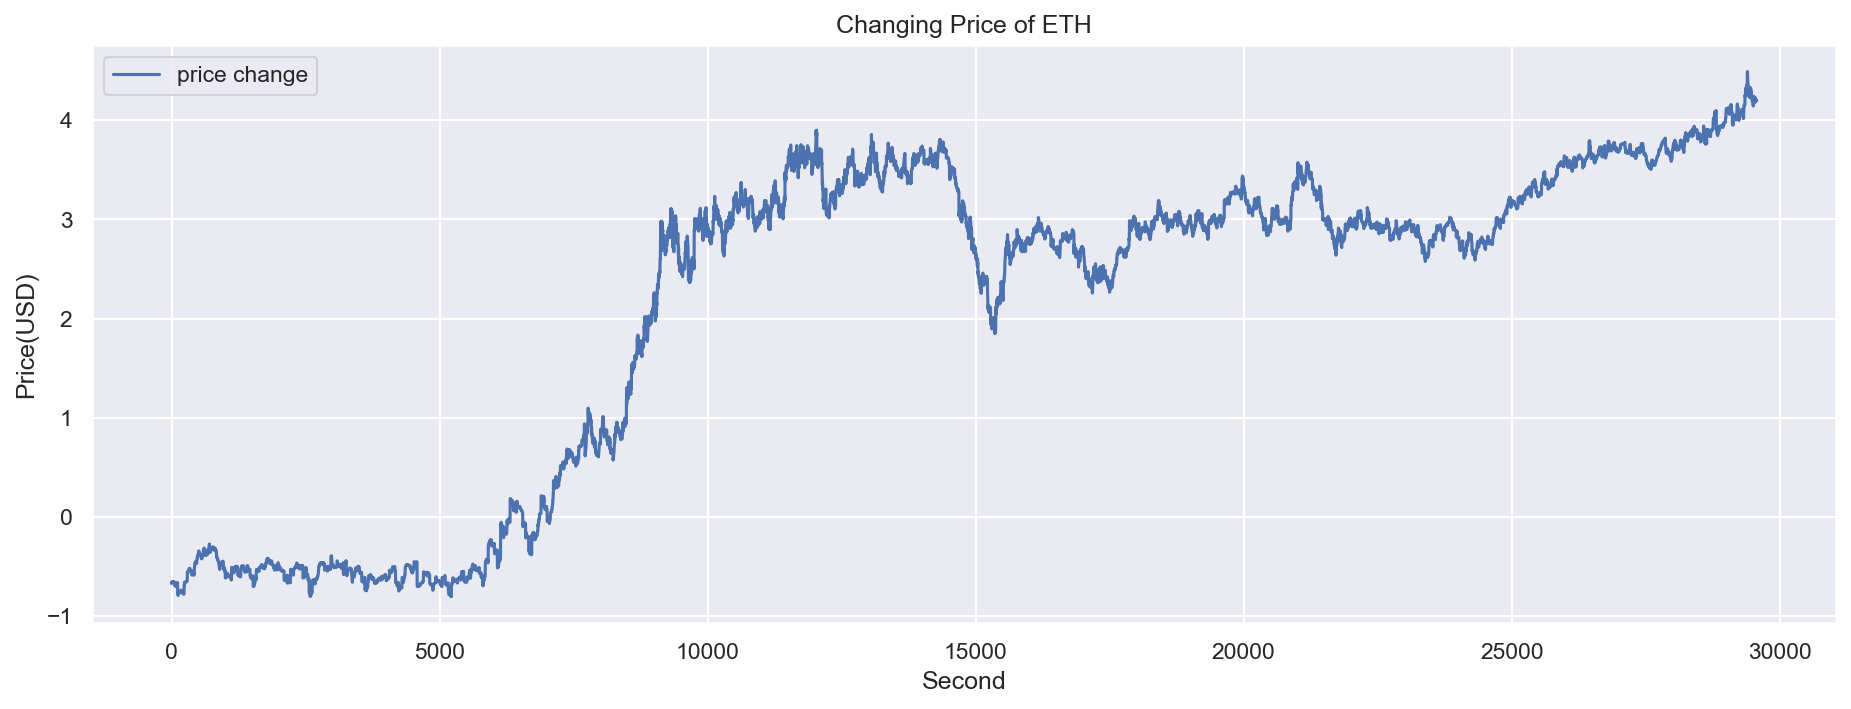

In [9]:
plt.figure(figsize=(15,5))
plt.plot(df['pct_chg'],label='price change')
plt.legend()
plt.title('Changing Price of ETH')
plt.xlabel('Second')
plt.ylabel('Price(USD)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Counts')

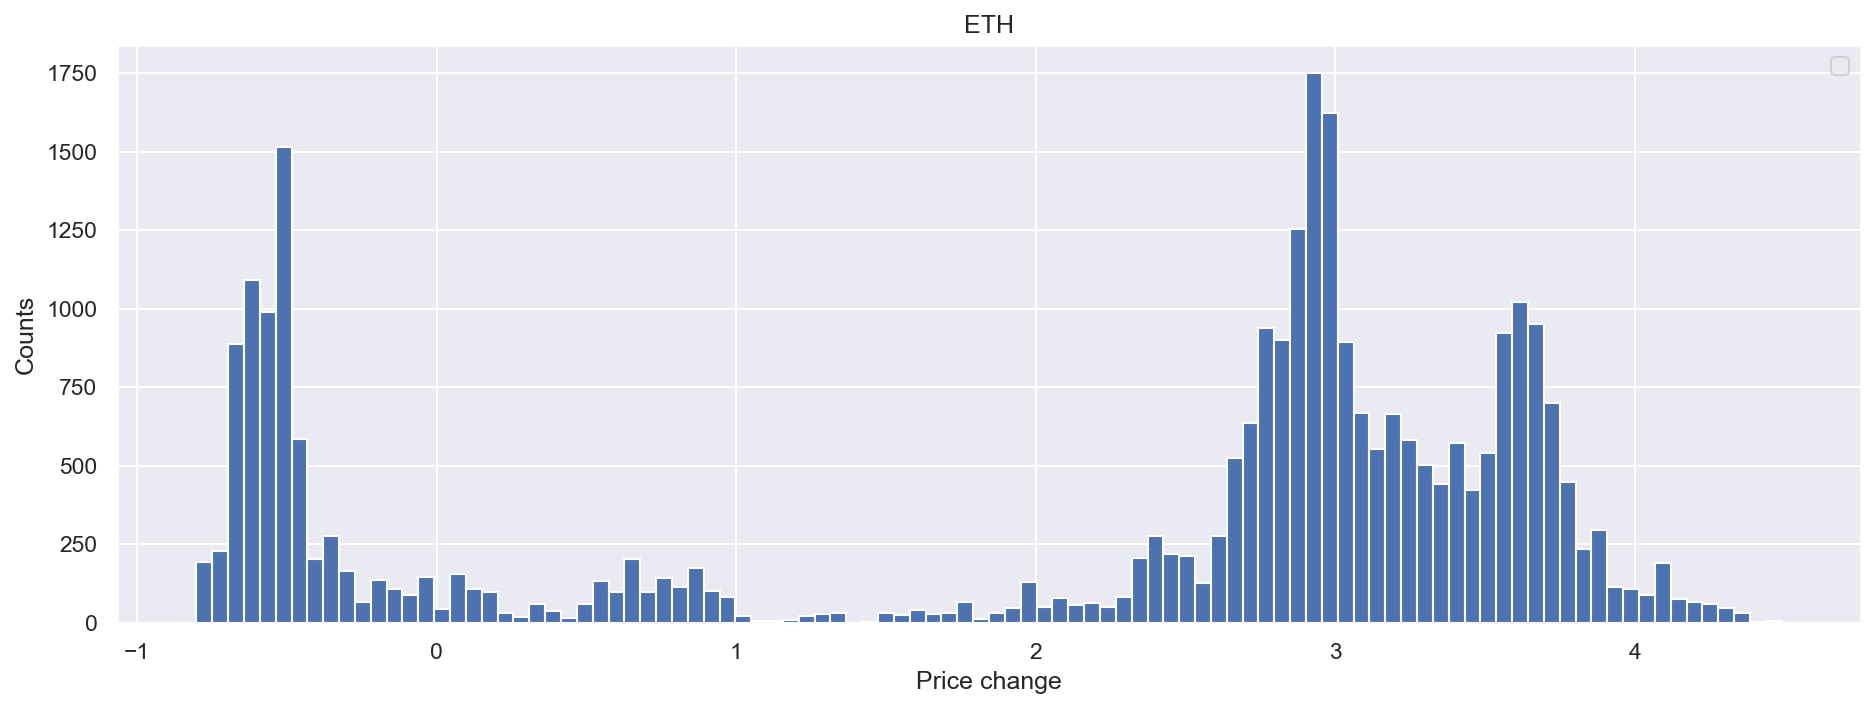

In [10]:
plt.figure(figsize=(15,5))
df['pct_chg'].hist(bins=100)
plt.legend()
plt.title('ETH')
plt.xlabel('Price change')
plt.ylabel('Counts')

Model

In [11]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len

23659

In [12]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.0545077 ],
       [0.05606506],
       [0.05710331],
       ...,
       [0.95890292],
       [0.95890292],
       [0.95890292]])

In [13]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(180, len(train_data)):
    x_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 181:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.0545077 , 0.05606506, 0.05710331, 0.05710331, 0.05710331,
       0.05710331, 0.05710331, 0.05770895, 0.05779547, 0.05779547,
       0.05770895, 0.05770895, 0.05779547, 0.05779547, 0.05779547,
       0.05770895, 0.05770895, 0.05779547, 0.05770895, 0.05770895,
       0.05779547, 0.05770895, 0.05770895, 0.05770895, 0.05770895,
       0.05770895, 0.05770895, 0.05770895, 0.05779547, 0.05779547,
       0.05770895, 0.05779547, 0.05779547, 0.05779547, 0.05779547,
       0.05710331, 0.05718983, 0.05710331, 0.05718983, 0.05710331,
       0.05710331, 0.05710331, 0.05718983, 0.05718983, 0.05718983,
       0.05710331, 0.05718983, 0.05718983, 0.05710331, 0.05718983,
       0.05710331, 0.05710331, 0.05718983, 0.05718983, 0.05718983,
       0.05710331, 0.05710331, 0.05710331, 0.05718983, 0.05710331,
       0.05710331, 0.05710331, 0.05710331, 0.05710331, 0.05710331,
       0.05718983, 0.05718983, 0.05710331, 0.05710331, 0.05710331,
       0.05710331, 0.05710331, 0.05710331, 0.05710331, 0.0571

In [14]:
print(x_train.shape)

print(dataset.shape)

(23479, 180, 1)
(29573, 1)


In [15]:
# Create the testing data set
# Create a new array containing scaled values from index 3154 to 2002 
test_data = scaled_data[training_data_len - 180: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = []
# y_test = dataset[training_data_len:, :]
for i in range(180, len(test_data)):
    x_test.append(test_data[i-180:i, 0])
    y_test.append(test_data[i, 0])
    if i<= 181:
        print(x_test)
        print(y_test)
        print()
    
# Convert the data to a numpy array
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

[array([0.74441945, 0.74441945, 0.74441945, 0.74727461, 0.74718809,
       0.74727461, 0.74727461, 0.74718809, 0.74727461, 0.74727461,
       0.74727461, 0.74666897, 0.74666897, 0.74666897, 0.74666897,
       0.74658245, 0.74666897, 0.74666897, 0.74666897, 0.74666897,
       0.74658245, 0.74666897, 0.74658245, 0.74658245, 0.74666897,
       0.74666897, 0.74666897, 0.74666897, 0.74753418, 0.7476207 ,
       0.74753418, 0.7476207 , 0.7476207 , 0.7476207 , 0.7480533 ,
       0.74796678, 0.74796678, 0.74796678, 0.74796678, 0.7480533 ,
       0.74796678, 0.74796678, 0.74191037, 0.740353  , 0.73697872,
       0.73853608, 0.73853608, 0.73853608, 0.73810348, 0.73810348,
       0.73498875, 0.73498875, 0.73498875, 0.73498875, 0.74286209,
       0.74796678, 0.74813982, 0.75471535, 0.75532099, 0.75532099,
       0.75523447, 0.75532099, 0.75523447, 0.75523447, 0.75947396,
       0.759647  , 0.75731095, 0.75808963, 0.75817616, 0.75808963,
       0.75601315, 0.75601315, 0.75601315, 0.75609967, 0.7560

In [16]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss= 'mean_squared_error', metrics= RootMeanSquaredError() )

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=100 ,verbose=1, validation_data= (x_test, y_test))

Epoch 1/100
734/734 [==============================] - 67s 85ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 4.7217e-05 - val_root_mean_squared_error: 0.0069
Epoch 2/100
734/734 [==============================] - 61s 84ms/step - loss: 3.7669e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.7738e-05 - val_root_mean_squared_error: 0.0042
Epoch 3/100
734/734 [==============================] - 54s 74ms/step - loss: 3.6785e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.4830e-05 - val_root_mean_squared_error: 0.0039
Epoch 4/100
734/734 [==============================] - 54s 74ms/step - loss: 4.1617e-05 - root_mean_squared_error: 0.0065 - val_loss: 2.2050e-05 - val_root_mean_squared_error: 0.0047
Epoch 5/100
734/734 [==============================] - 54s 74ms/step - loss: 4.7120e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.4898e-04 - val_root_mean_squared_error: 0.0122
Epoch 6/100
734/734 [==============================] - 54s 74ms/step - loss: 3.8407e-05 -

In [17]:
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
model.save("my_model.keras")

# It can be used to reconstruct the model identically.
reconstructed_model = load_model("my_model.keras")

# Let's check:
np.testing.assert_allclose(
    model.predict(x_test), reconstructed_model.predict(x_test)
)

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

y_test1 = dataset[training_data_len:, :]

# Get the root mean squared error (RMSE)
mse = mean_squared_error(y_test1, predictions)
print("Mean squared error : ", mse)

# Get the root mean squared error (RMSE)
rmse = mean_squared_error(y_test1, predictions, squared= False)
print("Root Mean squared error : ", rmse)


185/185 [==============================] - 7s 35ms/step
Mean squared error :  0.027306868509879484
Root Mean squared error :  0.1652479001678372


In [18]:
predictions

array([[2333.9714],
       [2333.9705],
       [2333.9758],
       ...,
       [2354.6592],
       [2354.6516],
       [2354.6501]], dtype=float32)

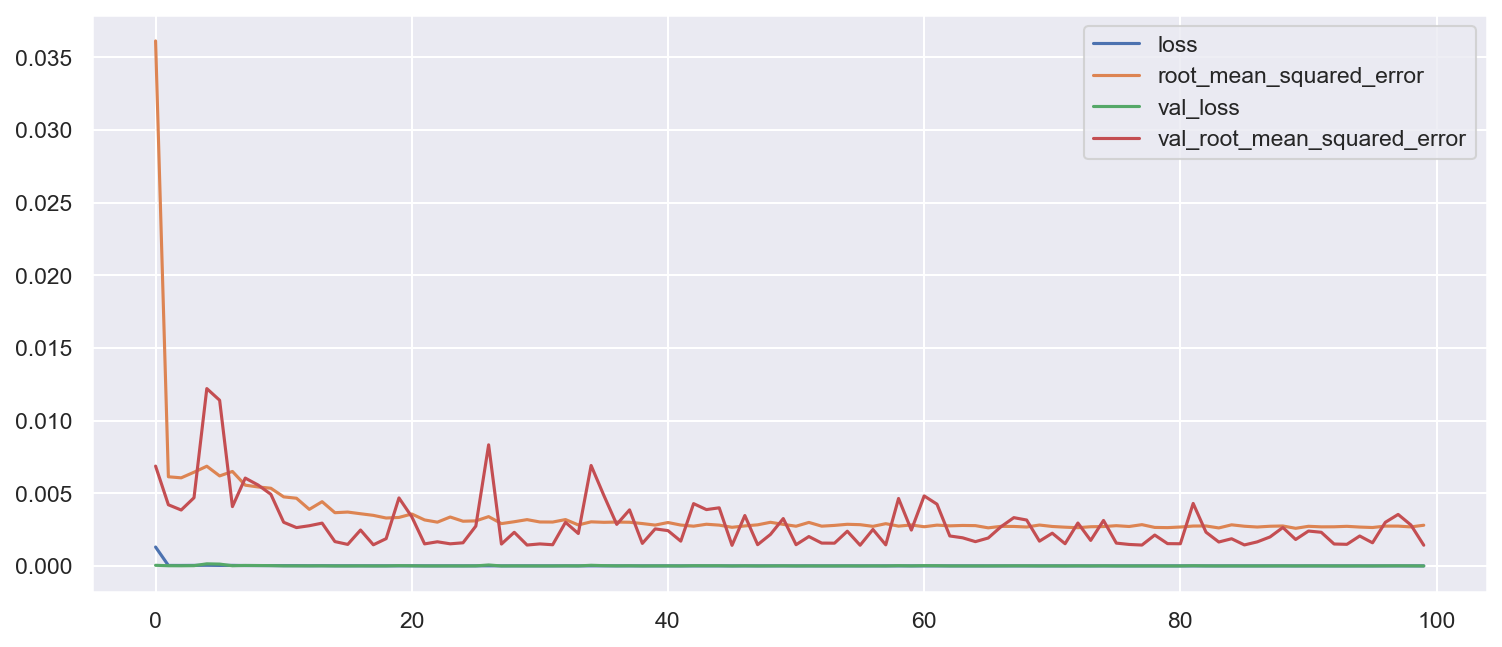

In [19]:
pd.DataFrame(history.history).plot(figsize=(12,5))
plt.show()

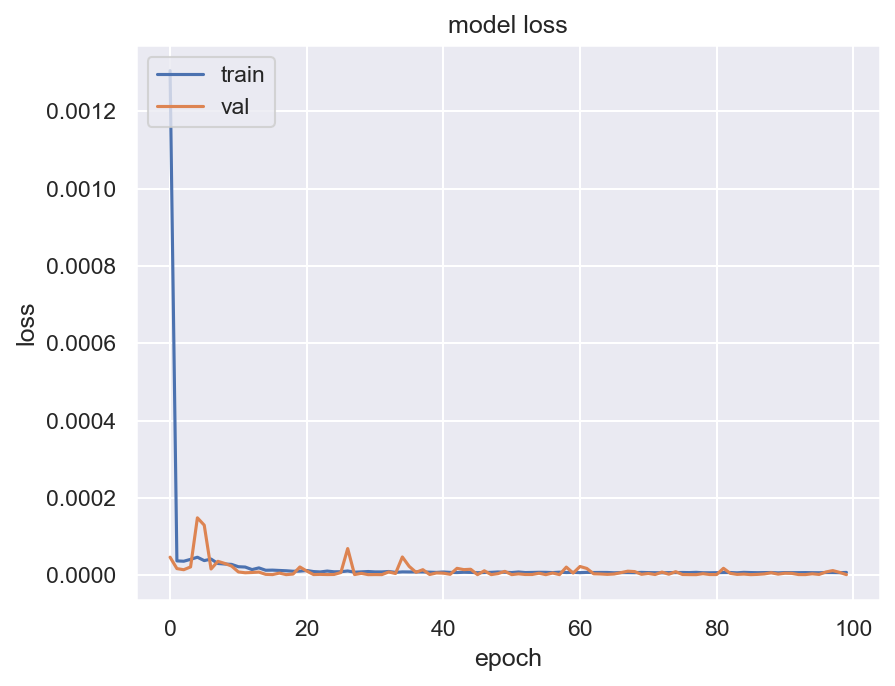

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

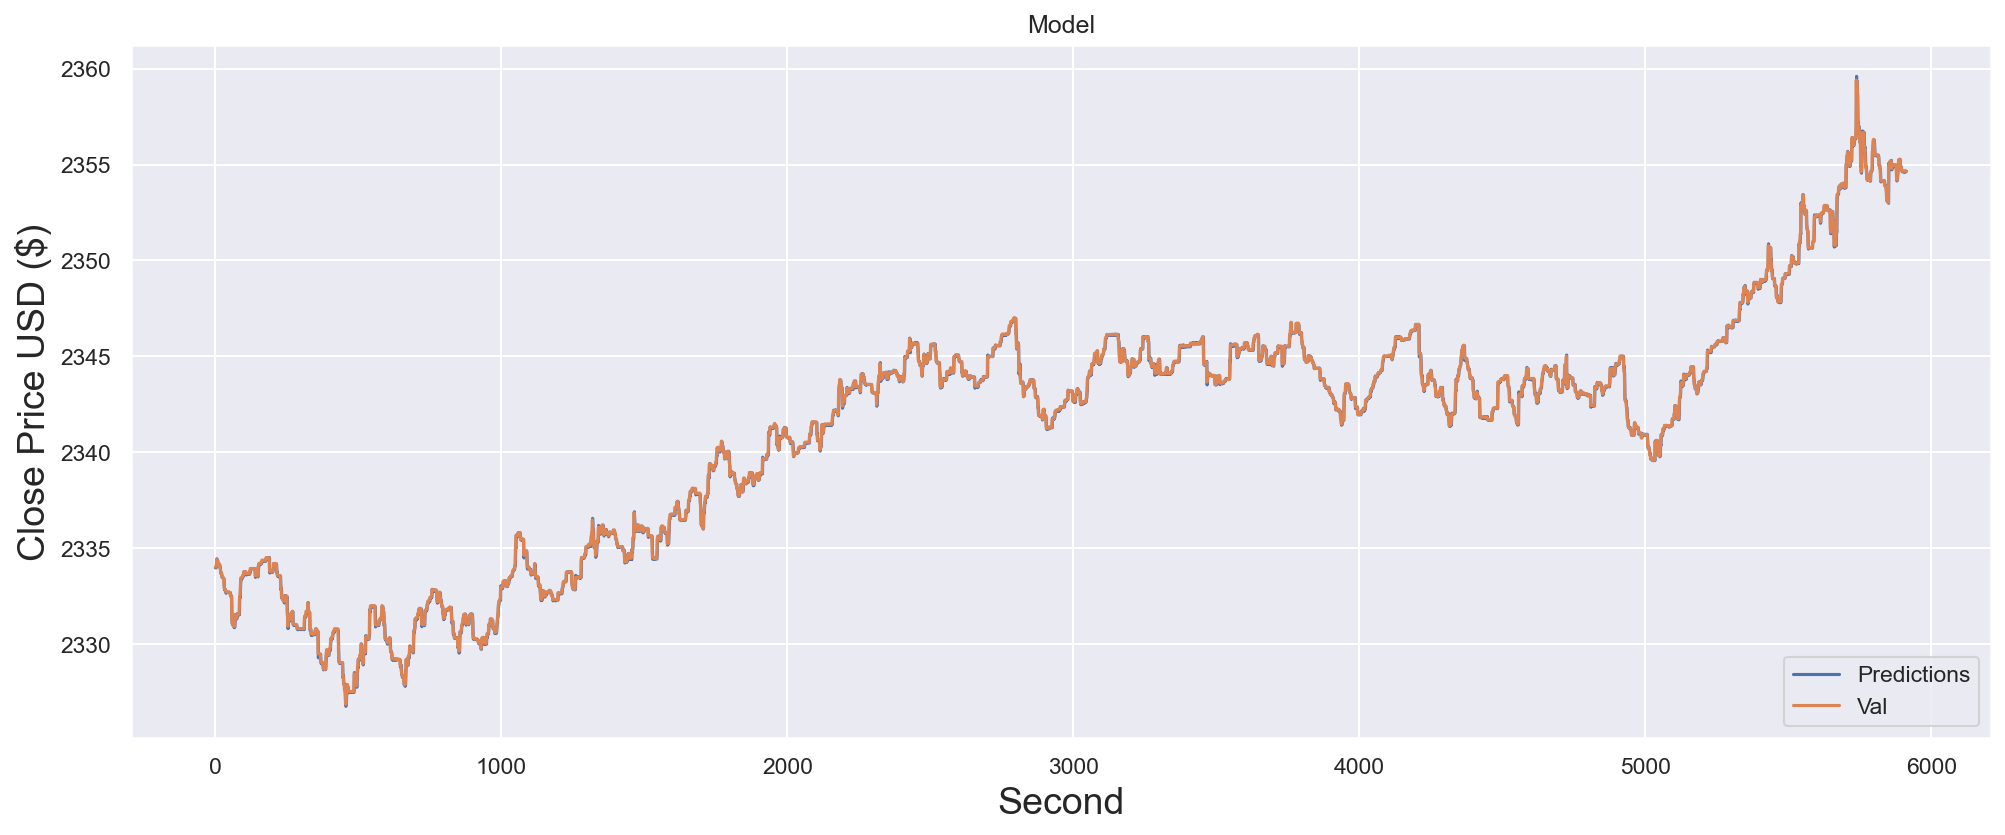

In [24]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Second', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(predictions)
plt.plot(y_test1)
plt.legend(['Predictions', 'Val'], loc='lower right')
plt.show()

C:\Users\hellp\AppData\Local\Temp\ipykernel_29600\2074067586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


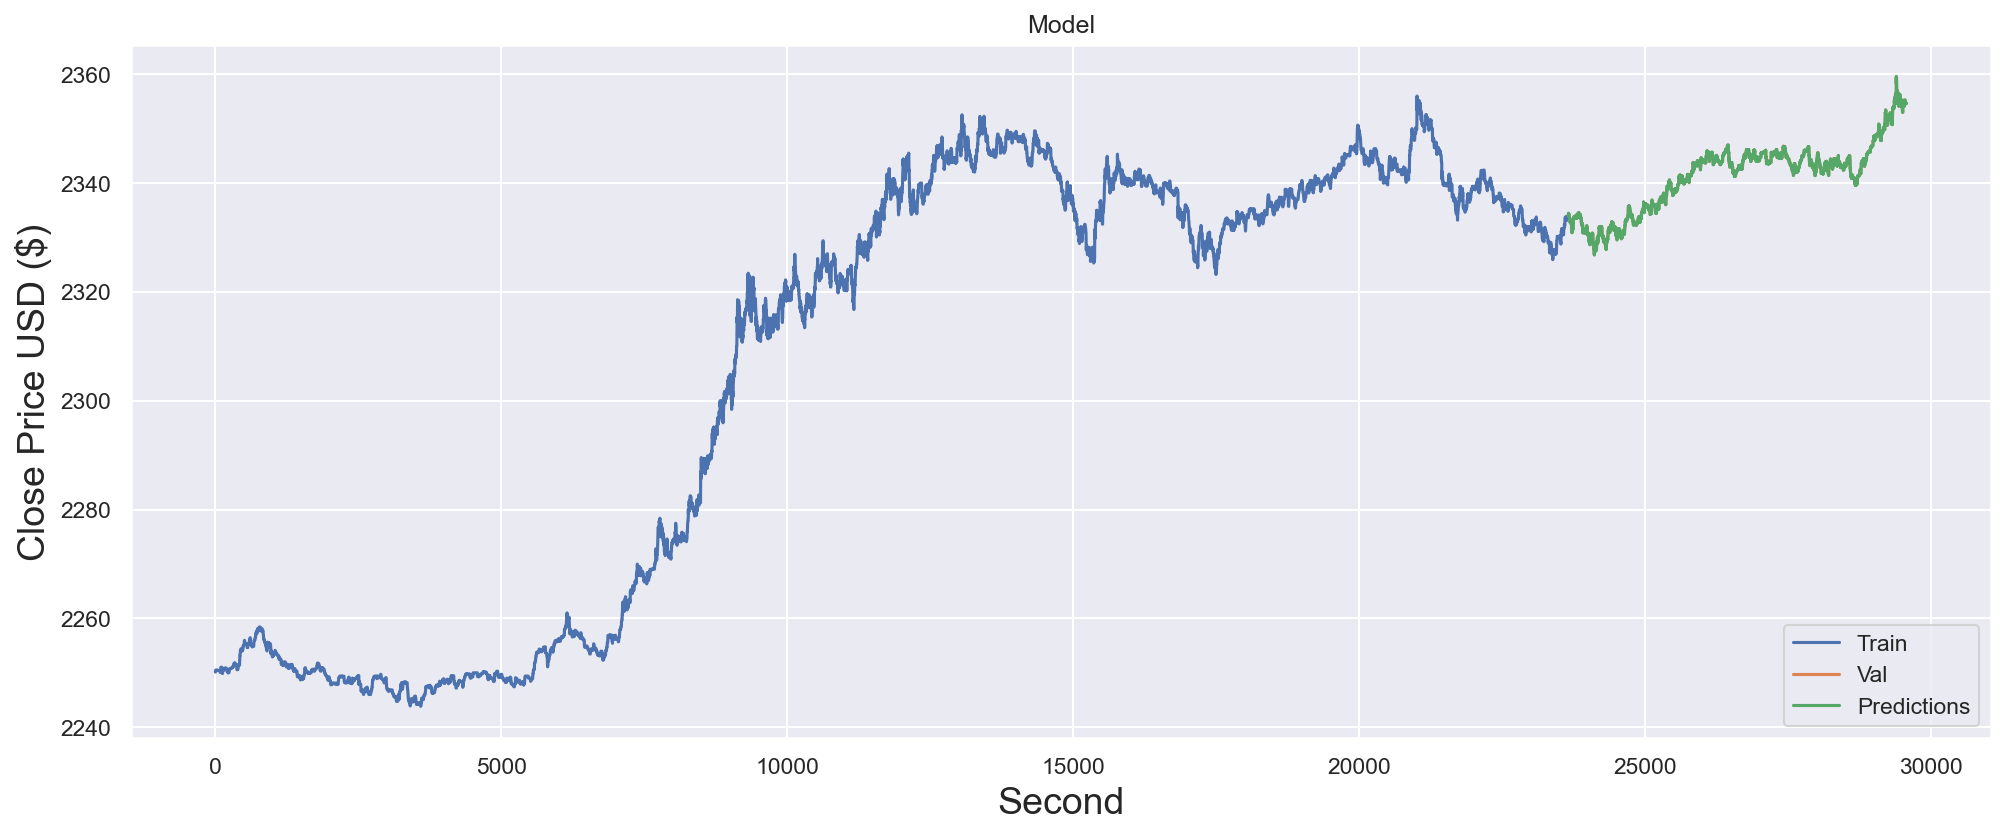

In [25]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Second', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [27]:
# Show the valid and predicted prices
valid

,close,Predictions
23659,2334.02,2333.971436
23660,2334.01,2333.970459
23661,2334.01,2333.975830
23662,2334.06,2333.974609
23663,2334.39,2334.033447
...,...,...
29568,2354.66,2354.651855
29569,2354.66,2354.603760
29570,2354.65,2354.659180
29571,2354.65,2354.651611
